In [3]:
import sys
sys.path.append("..")

import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
import numpyro
from numpyro import distributions as dist
from numpyro import infer

from numpyro_ext import distributions as distx
from numpyro_ext import info, optim

jax.config.update("jax_enable_x64", True)
numpyro.set_host_device_count(2)

from jaxoplanet import light_curves, orbits
import arviz as az
import corner

from core.jax import oblate_lightcurve

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


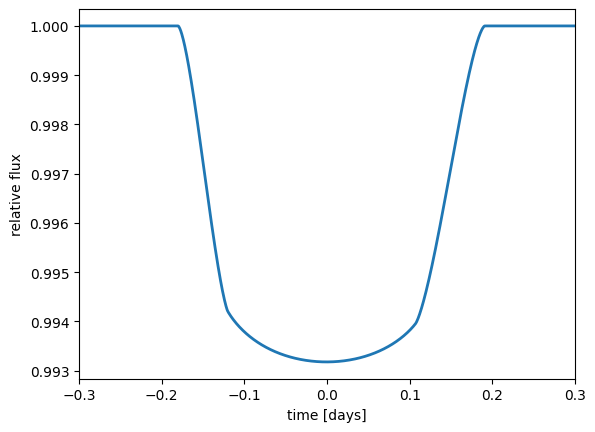

In [4]:
#Fiducial planet parameters:
params = {'period':300.456,
          'radius':0.1,
          'u':jnp.array([0.3,0.2]),
          'f':0.3,
          'bo':0.8,
          'theta':jnp.radians(35)
}
# The light curve calculation requires an orbit

# Compute a limb-darkened light curve using starry
t = jnp.linspace(-0.3, 0.3, 1000)
oblate_lightcurve = jit(oblate_lightcurve)
lc = oblate_lightcurve(params,t)

plt.plot(t, lc/lc[0], color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

{'period': 7.704045333151538, 't0': 1.0, 'radius': 0.1, 'bo': 0.8, 'u': Array([0.3, 0.2], dtype=float64), 'f': 0.3, 'theta': 0.6108652381980153}


Text(0.5, 0, 'Time')

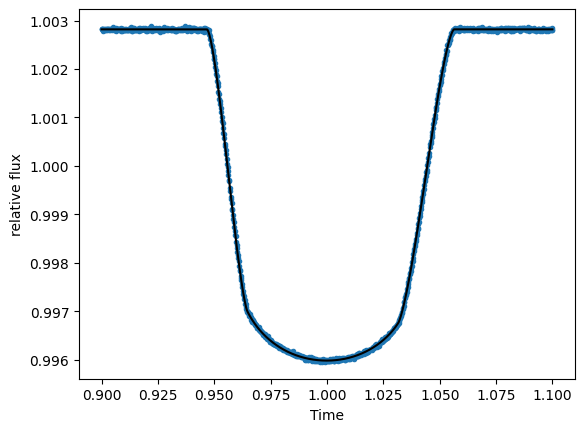

In [5]:
np.random.seed(11)
period_true = np.random.uniform(5, 20)
t = np.linspace(0.9,1.1,1000)
yerr = 50*1e-6

true_params = {'period':period_true,
               't0':1.0,
                'radius':0.1,
                'bo':0.8,
                'u':jnp.array([0.3, 0.2]),
                'f':0.3,
                'theta':np.radians(35)
} 

print(true_params)

# Compute a limb-darkened light curve using starry
lc_true = oblate_lightcurve(true_params, t-true_params['t0'])

lc = lc_true + yerr*np.random.normal(size=len(t))

ax = plt.subplot()
ax.plot(t, lc/jnp.mean(lc), 'C0.')
ax.plot(t, lc_true/jnp.mean(lc), color='k')
ax.set_ylabel("relative flux")
ax.set_xlabel("Time")

In [9]:
numpyro.enable_x64()
def model(t, yerr, y=None):
    # If we wanted to fit for all the parameters, we could use the following,
    # but we'll keep these fixed for simplicity.
    
    #log_duration = numpyro.sample("log_duration", dist.Uniform(jnp.log(0.08), jnp.log(0.2)))
    #b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    log_jitter = numpyro.sample("log_jitter", dist.Normal(jnp.log(yerr), 1.0))
    log_r = numpyro.sample("log_r", dist.Normal(jnp.log(0.1), 2.0))
    r = numpyro.deterministic("r", jnp.exp(log_r))
    u1 = numpyro.sample("u1", dist.Normal(0.3, 0.1))
    u2 = numpyro.sample("u2", dist.Normal(0.2, 0.1))
    bo = numpyro.sample("bo", dist.Uniform(0,1))
    f = numpyro.sample("f", dist.Uniform(0,1))
    theta = numpyro.sample("theta", dist.Uniform(0,jnp.pi))
    params = {
        'period':period_true,
        't0': 1.0,
        "radius": r,
        'bo':bo,
        'u': jnp.array([u1,u2]),
        'f':f, 
        'theta':theta       
    }

    numpyro.sample(
        "flux",
        dist.Normal(
            oblate_lightcurve(params, t-true_params['t0']), jnp.sqrt(yerr**2 + jnp.exp(2 * log_jitter))
        ),
        obs=y,
    )

### Oblate MCMC Fit

In [10]:
init_params = {'period':period_true,
                't0':1.0,
                'log_r':jnp.log(true_params['radius']),
                'u':jnp.array([0.3, 0.2]),
                'f':0.1,
                'bo':0.7,
                'theta':jnp.radians(0)
               
} 

In [ ]:
sampler_wn = infer.MCMC(
    infer.NUTS(
        model,
        target_accept_prob=0.9,
        dense_mass=False,
        init_strategy=infer.init_to_value(values=init_params),
        regularize_mass_matrix=False,
    ),
    num_warmup=1000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler_wn.run(jax.random.PRNGKey(11), t, yerr, lc)

In [ ]:
inf_data_wn = az.from_numpyro(sampler_wn)
az.summary(inf_data_wn, var_names=["log_jitter", "log_r", "u1", "u2", "bo", "f", "theta"])

### Oblate Nested Sampling Fit

In [8]:
from numpyro.contrib.nested_sampling import NestedSampler
from jaxns.prior_transforms.prior import UniformBase

In [11]:
ns = NestedSampler(model)
ns.run(jax.random.PRNGKey(2), t, yerr, lc)

ns_samples = ns.get_samples(jax.random.PRNGKey(121), num_samples=10000)

WARNING[2023-10-11 12:01:07,376]: Increasing max_samples (100000) by 100 to evenly divide samples_per_step


In [ ]:
inf_data = az.from_dict(ns_samples, dropna=True)
az.summary(inf_data, var_names=["log_jitter", "log_r", "u1", "u2", "bo", "f", "theta"])
